# goal of this is to look at the gateway transport for the season

Compute Total Heat Transport (AW Inflow vs. Local Heat Content)

Q_AW = rhoCp integral over depth (u * T)dz

This notebook should be modified from the previous version to ID
- from the gateway transports, loaded from file, where are the indices of inflow and outflow at each gate
- can we compute a timeseries of heat transport for inflow and outflow

In [17]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from binning import *                    # bin_array, create_mesh

# ignore memory warnings
import warnings
warnings.filterwarnings('ignore')

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import shapely.geometry as sg


In [2]:
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")

from get_Jterms import *

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



In [3]:
%run /home/mmurakami/crios_backups/an_helper_functions/prep_grid.py

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



In [4]:
# calculate the sea ice edge for 1 and 2
thresh = .15  # 15% sea ice coverage as Barton

# fig = plt.figure(figsize=(8,5))

# plot the basins, color by label
landmsk = np.zeros((ny,nx))
landmsk[np.isnan(hfC[0])] = 2
landmsk[hfC[0] == 1] = np.nan

# add the land
# plt.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],cmap='RdBu')

In [5]:
# calculate the sea ice edge for 1 and 2
thresh = .15  # 15% sea ice coverage as Barton

# fig = plt.figure(figsize=(8,5))

# plot the basins, color by label
landmsk = np.zeros((ny,nx))
landmsk[np.isnan(hfC[0])] = 2
landmsk[hfC[0] == 1] = np.nan

# add the land
# plt.pcolormesh(get_aste_tracer(hfC,nfx,nfy)[0],cmap='RdBu')

In [6]:
# ocean and ice
AB_gT=0
AB_gS=0
dt_aste = 600
startyr = 2002
endyr = 2019              # for ASTE R1

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)
allyears = np.arange(2003,2018,1)

In [7]:
x_bso = gg['BarentsSeaOpening']["ix"]-1   # 0 
y_bso = gg['BarentsSeaOpening']["jy"]-1
x_bso[x_bso == 162] = 161

x_sfj = gg['Svalbard-FranzJosefIslands']["ix"]-1   # 1
y_sfj = gg['Svalbard-FranzJosefIslands']["jy"]-1
x_sfj,y_sfj = x_sfj[1:],y_sfj[1:]

x_fjnz = gg['FranzJosefIslands-NovayaZemlya']["ix"]-1  #2 
y_fjnz = gg['FranzJosefIslands-NovayaZemlya']["jy"]-1

# x_sta_vilkit = gg['StAnnaTrough/Voronin/Vilkitshogo']["ix"]-1  #3
# y_sta_vilkit = gg['StAnnaTrough/Voronin/Vilkitshogo']["jy"]-1

test = np.full(mskBasin.shape,np.nan)
test[y_bso,x_bso] = 1
test[y_sfj,x_sfj] = 2
test[y_fjnz,x_fjnz] = 3
# test[y_sta_vilkit,x_sta_vilkit] = 4

In [8]:
def line_orientation(x, y):
    orientations = np.array([])

    # Iterate through the list of points
    for i in range(1, len(x)):
        if x[i] == x[i - 1] and y[i] != y[i - 1]:
            orientations = np.append(orientations,"V") # vertical line add zonal transp
        elif y[i] == y[i - 1] and x[i] != x[i - 1]:
            orientations = np.append(orientations,"H") # horizontal line add meridional transp
        else:
            orientations = np.append(orientations,"V")  # fill na should be for top of vertical line (ie U)

    # the last one will be the same as the second to last orientation so we can keep consistent sizing
    orientations = np.append(orientations,orientations[-1])

    return orientations
choose_UV_bso = line_orientation(y_bso,x_bso)
choose_UV_sfj = line_orientation(y_sfj,x_sfj)
choose_UV_fjnz = line_orientation(y_fjnz,x_fjnz)

# start by loading the timeseries that we made at each gate

In [9]:
# To load later
loaded_data = np.load("/scratch2/mmurakami/aste_270x450x180/ASTER1/timeseries_data.npy", allow_pickle=True).item()

# Access the saved dictionaries
heat_transport_timeseries = loaded_data["heat_transport_timeseries"]   # contains ADV_TH positive into the barents sea (degC.m^3/s)
theta_timeseries = loaded_data["theta_timeseries"]                     # 
salt_timeseries = loaded_data["salt_timeseries"]
binned_theta_timeseries = loaded_data["binned_theta_timeseries"]
binned_salt_timeseries = loaded_data["binned_salt_timeseries"]


loaded_data = np.load("/scratch2/mmurakami/aste_270x450x180/ASTER1/timeseries_data_advslt.npy", allow_pickle=True).item()
salt_transport_timeseries = loaded_data["salt_transport_timeseries"] # contains ADV_SLT positive into the Barents Sea (PSU.m^3/s)

loaded_data = np.load("/scratch2/mmurakami/aste_270x450x180/ASTER1/timeseries_data_velmass.npy", allow_pickle=True).item()
velmass_timeseries = loaded_data["velmass_timeseries"] # contains UVEL and VVELMASS (m/s)

# identify indices of inflow and outflow

In [10]:
gates = velmass_timeseries.keys()
gates

dict_keys(['BSO', 'SFJ', 'FJNZ'])

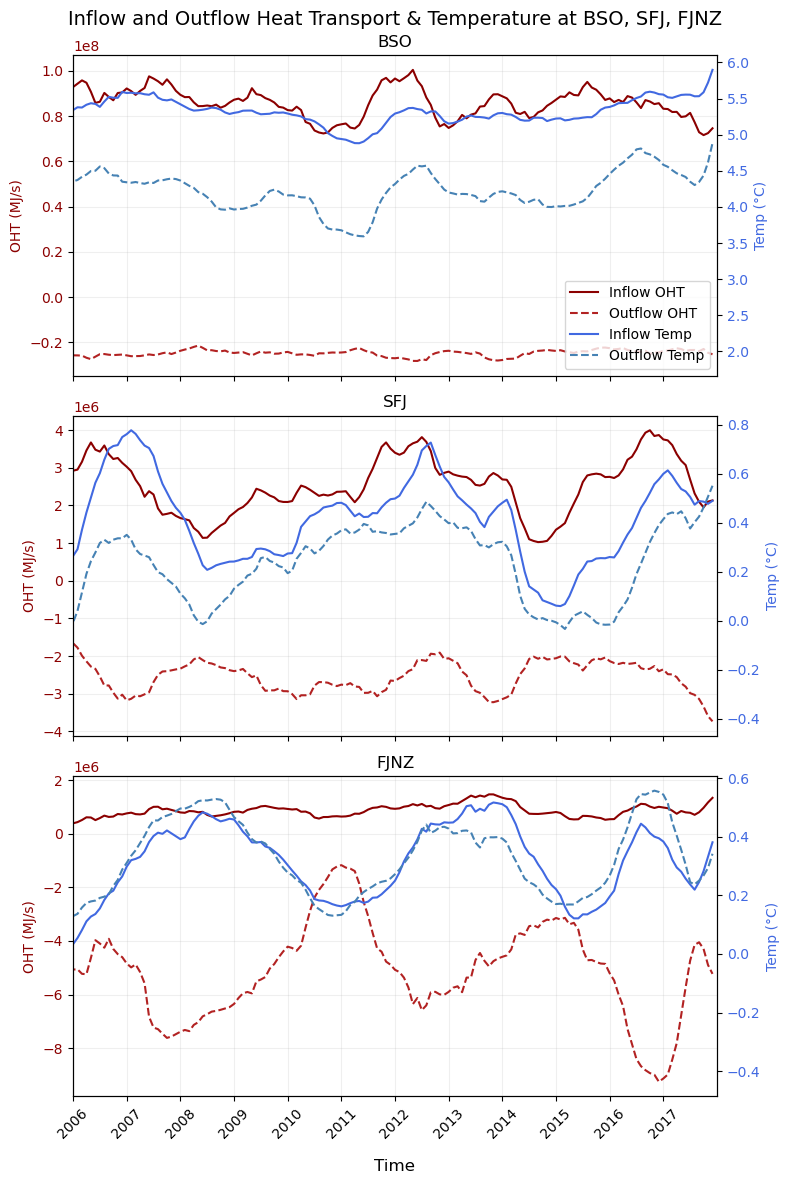

In [11]:
fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=True)

xtick_positions = np.arange(0, 15*12, 12)
xtick_labels = np.arange(2003, 2018)
time = np.arange(0, 15*12)
window_size = 12  # months

for i, gate in enumerate(gates):
    ax1 = axes[i]
    vel = velmass_timeseries[gate]
    theta = theta_timeseries[gate]
    Q = heat_transport_timeseries[gate] * myparms['rcp'] * 1e-6  # MJ/s

    # Masks
    inflow_mask = vel > 0
    outflow_mask = vel < 0

    # Temperature
    T_inflow = np.nansum(theta * inflow_mask, axis=(2, 3)) / np.nansum(inflow_mask, axis=(2, 3))
    T_outflow = np.nansum(theta * outflow_mask, axis=(2, 3)) / np.nansum(outflow_mask, axis=(2, 3))

    # Heat transport
    Q_inflow = np.nansum(Q * inflow_mask, axis=(2, 3))
    Q_outflow = np.nansum(Q * outflow_mask, axis=(2, 3))

    # Smooth
    heat_in_smooth = pd.Series(Q_inflow.flatten()).rolling(window=window_size, center=True, min_periods=1).mean()
    heat_out_smooth = pd.Series(Q_outflow.flatten()).rolling(window=window_size, center=True, min_periods=1).mean()
    temp_in_smooth = pd.Series(T_inflow.flatten()).rolling(window=window_size, center=True, min_periods=1).mean()
    temp_out_smooth = pd.Series(T_outflow.flatten()).rolling(window=window_size, center=True, min_periods=1).mean()

    # Plot heat transport
    ax1.plot(time, heat_in_smooth, color="darkred", label="Inflow OHT")
    ax1.plot(time, heat_out_smooth, color="firebrick", linestyle="--", label="Outflow OHT")
    ax1.set_ylabel("OHT (MJ/s)", color="darkred")
    ax1.tick_params(axis='y', labelcolor="darkred")
    ax1.set_title(f"{gate}")
    ax1.set_xticks(xtick_positions)
    ax1.set_xticklabels(xtick_labels, rotation=45)
    ax1.set_xlim(3*12, 15*12)
    ax1.grid(alpha=0.2)

    # Twin axis for temperature
    ax2 = ax1.twinx()
    ax2.plot(time, temp_in_smooth, color="royalblue", label="Inflow Temp")
    ax2.plot(time, temp_out_smooth, color="steelblue", linestyle="--", label="Outflow Temp")
    ax2.set_ylabel("Temp (°C)", color="royalblue")
    ax2.tick_params(axis='y', labelcolor="royalblue")
    ax2.set_xlim(3*12, 15*12)

    # Add combined legend only to the first subplot
    if i == 0:
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc="lower right")

# Set shared x-label
fig.supxlabel("Time")
fig.suptitle("Inflow and Outflow Heat Transport & Temperature at BSO, SFJ, FJNZ", fontsize=14)
plt.tight_layout()

plt.savefig("figs/inout_timeseries.png",dpi=300)
plt.show()

In [12]:
mymsk = np.zeros((ny,nx))
idxs = np.where(mskBasin == 6)

for i,j in zip (idxs[0],idxs[1]):
    mymsk[i,j] = 1

In [13]:
# do the same plot but overlay with sea ice area instead
# do SIarea

# loop through the years to create the timeseries
alldatetimes = np.array([])
SIareas = np.zeros((len(allyears),12))

iy = 0
for year in allyears:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    ## 
    # get the SIarea values

    SIarea = np.full((len(tsstr),ny,nx),np.nan)  # 2D field 
    
    for i in range(len(tsstr)):
    
        # read the fldList
        file_name = 'state_2d_set1'
        meta_state_2d_set1 = parsemeta(dirState + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_state_2d_set1["fldList"])
        varnames = np.array(["SIarea"])
        recs = np.array([])
        for var in varnames:
            irec = np.where(fldlist == var)
            recs = np.append(recs, irec[0][0])
            
        read = [int(tsstr[i])]
        
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        # this is wrong, this is the fractional area -- to get the actual area we need to multiply by RAC
        SIareai,its,meta = rdmds(os.path.join(dirState, file_name),read,returnmeta=True,rec=recs[0])  # m^2/m^2
        SIarea[i,:,:] = np.reshape(SIareai,(ny,nx))*mymsk*RAC  # m^2


        # get the total SIarea for that time
        if i in [10,11,0,1,2,3]:  # november-april
            SIareas[iy,i] = np.nansum(SIarea[i,:,:])
        else:
            SIareas[iy,i] = np.full(np.nansum(SIarea[i,:,:]).shape,np.nan)
        #alldatetimes = np.append(alldatetimes,datetimes[i])

    iy += 1

2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


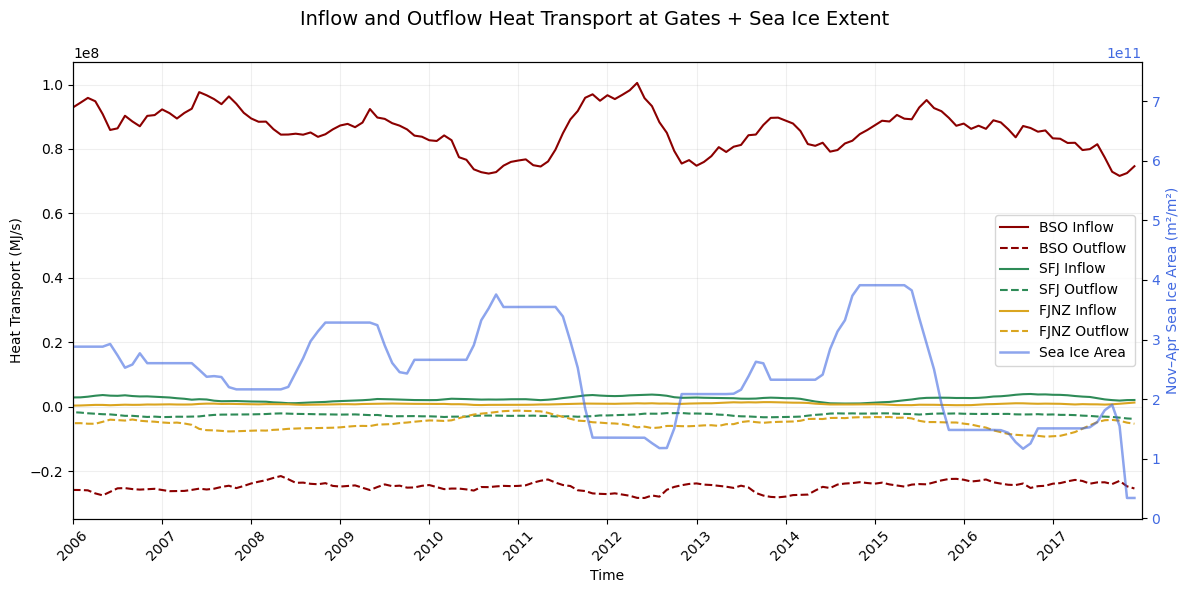

In [14]:
gates = ['BSO', 'SFJ', 'FJNZ']
# gates = ['SFJ', 'FJNZ']
colors = {'BSO': 'darkred', 'SFJ': 'seagreen', 'FJNZ': 'goldenrod'}
linestyles = {'inflow': '-', 'outflow': '--'}

window_size = 12
time = np.arange(0, 15 * 12)
xtick_positions = np.arange(0, 15 * 12, 12)
xtick_labels = np.arange(2003, 2018)

# Sea ice extent smoothing
SI_smoothed = pd.Series(SIareas.flatten()).rolling(window=window_size, center=True, min_periods=1).mean()

# --- Create figure ---
fig, ax1 = plt.subplots(figsize=(12, 6))

# --- Loop over gates and plot heat transport ---
for gate in gates:
    vel = velmass_timeseries[gate]
    Q = heat_transport_timeseries[gate] * myparms['rcp'] * 1e-6  # MJ/s

    inflow_mask = vel > 0
    outflow_mask = vel < 0

    Q_in = np.nansum(Q * inflow_mask, axis=(2, 3))
    Q_out = np.nansum(Q * outflow_mask, axis=(2, 3))

    heat_in_smooth = pd.Series(Q_in.flatten()).rolling(window=window_size, center=True, min_periods=1).mean()
    heat_out_smooth = pd.Series(Q_out.flatten()).rolling(window=window_size, center=True, min_periods=1).mean()

    ax1.plot(time, heat_in_smooth, label=f"{gate} Inflow", color=colors[gate], linestyle=linestyles['inflow'])
    ax1.plot(time, heat_out_smooth, label=f"{gate} Outflow", color=colors[gate], linestyle=linestyles['outflow'])

# --- Primary axis: Heat Transport ---
ax1.set_ylabel("Heat Transport (MJ/s)", color="black")
ax1.tick_params(axis='y', labelcolor="black")
ax1.set_xticks(xtick_positions)
ax1.set_xticklabels(xtick_labels, rotation=45)
ax1.set_xlim(3 * 12, 15 * 12)
ax1.grid(alpha=0.2)

# --- Twin axis: Sea Ice Extent ---
ax2 = ax1.twinx()
ax2.plot(time, SI_smoothed, color="royalblue", linewidth=1.8, alpha=0.6, label="Sea Ice Area")
ax2.set_ylabel("Nov–Apr Sea Ice Area (m²/m²)", color="royalblue")
ax2.tick_params(axis='y', labelcolor="royalblue")
ax2.set_xlim(3 * 12, 15 * 12)

# --- Legends ---
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="center right")

# --- Labels and Title ---
ax1.set_xlabel("Time")
fig.suptitle("Inflow and Outflow Heat Transport at Gates + Sea Ice Extent", fontsize=14)

plt.tight_layout()

# plt.savefig("figs/heat_ice_timeseries_withoutBSO.png",dpi=300)

plt.show()

# it makes sense to subdivide these gates more based on the water masses themselves

In [15]:
# do a T-S diagram with the labels 


# add the isopycnals
# add the density contours from gsw
smin = 25.5 - (0.01 * 25.5)    #salt_ctrl_subregR.min - (0.01 * salt_ctrl_subregR.min)
smax = 38 + (0.01 * 38)    #salt_ctrl_subregR.max + (0.01 * salt_ctrl_subregR.max)
tmin = -2 + (0.1 * -2)       #temp_ctrl_subregR.min - (0.1 * temp_ctrl_subregR.max)
tmax = 31 + (0.1 * 31)       #temp_ctrl_subregR.max + (0.1 * temp_ctrl_subregR.max)
print('tmin, tmax, smin, smax sizes=,', tmin, tmax, smin, smax)
# Calculate how many gridcells we need in the x and y dimensions
xdim = 50
ydim = 50
# Create empty grid of zeros
dens = np.zeros((ydim,xdim))
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(-2,31,ydim)
si = np.linspace(25.5,38,xdim)
Freez_temp = gsw.CT_freezing(si,0,0)

Si, Ti = np.meshgrid(si, ti, sparse=False, indexing='ij')
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        #print(si[i],ti[j])
        dens[j,i]=gsw.rho(si[i],ti[j],0)
        # Substract 1000 to convert to sigma-0
dens2 = dens - 1000

tmin, tmax, smin, smax sizes=, -2.2 34.1 25.245 38.38


In [51]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

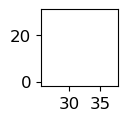

In [53]:
# create the polygons for the next plot
fig = plt.figure(figsize=(1,1))
ax = fig.add_subplot(1, 1, 1)

# add BSW values
cs = ax.contourf(si, ti, dens2, levels=[27.85,31],colors="black", zorder=1,alpha=0,linestyles='-.')
cl=plt.clabel(cs,fontsize=10,inline=False,fmt="%.2f")
# get the dens2ity vertices
p = cs.collections[0].get_paths()[0]
v = p.vertices
# get the TS vertices
s = np.array([34.7,36,36,34.7,34.7])
t = np.array([-3,-3,2,2,-3])
b = np.array([[a,b] for a,b in zip(s,t)])
# # find intersection and plot
a = sg.Polygon(v)
b = sg.Polygon(b)
ft = Freez_temp
si2 = si.copy()
si2 = np.append(si2,[max(si2),min(si2),min(si2)])
ft = np.append(ft,[0.1,0.1,max(ft)])
c = np.array([[a,b] for a,b in zip(si2,ft)])
c = sg.Polygon(c)
d = a.intersection(b)
bsw = d #c.intersection(d)

# find the CW values
s = np.array([33,34.7,34.7,33,33])
t = np.array([2,2,10,10,2])
b = np.array([[a,b] for a,b in zip(s,t)])
# # find intersection and plot
b = sg.Polygon(b)
cw = b

# find the ArW values
s = np.array([34.2,34.75,34.75,34.2,34.2])
t = np.array([-2,-2,0,0,-2])
b = np.array([[a,b] for a,b in zip(s,t)])
# # find intersection and plot
b = sg.Polygon(b)
arw = b

# find the AW values
s = np.array([34.8,36,36,34.8,34.8])
t = np.array([3,3,10,10,3])
b = np.array([[a,b] for a,b in zip(s,t)])
b = sg.Polygon(b)
aw = b

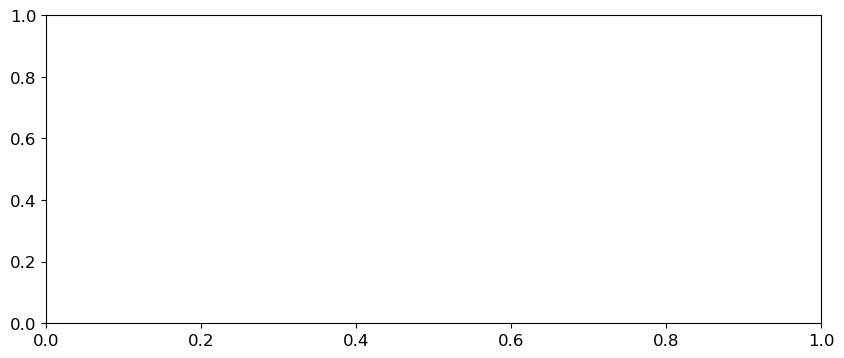

In [56]:
# --- Existing Water Mass Polygons ---

# BSW
cs = ax.contourf(si, ti, dens2, levels=[27.85,31], colors="black", zorder=1, alpha=0, linestyles='-.')
cl = plt.clabel(cs, fontsize=10, inline=False, fmt="%.2f")
v = cs.collections[0].get_paths()[0].vertices
a = sg.Polygon(v)

s_bsw = np.array([34.7,36,36,34.7,34.7])
t_bsw = np.array([-3,-3,2,2,-3])
b_bsw = sg.Polygon(np.column_stack((s_bsw, t_bsw)))
bsw = a.intersection(b_bsw)

# CW
s_cw = np.array([33,34.7,34.7,33,33])
t_cw = np.array([2,2,10,10,2])
cw = sg.Polygon(np.column_stack((s_cw, t_cw)))

# ArW
s_arw = np.array([34.2,34.75,34.75,34.2,34.2])
t_arw = np.array([-2,-2,0,0,-2])
arw = sg.Polygon(np.column_stack((s_arw, t_arw)))

# AW
s_aw = np.array([34.8,36,36,34.8,34.8])
t_aw = np.array([3,3,10,10,3])
aw = sg.Polygon(np.column_stack((s_aw, t_aw)))

# --- New Water Mass Polygons ---

# MW: t > 0, S < 34.2
s_mw = np.array([32,34.2,34.2,32,32])
t_mw = np.array([0,0,10,10,0])
mw_full = sg.Polygon(np.column_stack((s_mw, t_mw)))
# Subtract CW and ArW
mw = mw_full.difference(cw.union(arw))

# SBW: 1 < t < 3, S < 34.4
s_sbw = np.array([32,34.4,34.4,32,32])
t_sbw = np.array([1,1,3,3,1])
sbw_full = sg.Polygon(np.column_stack((s_sbw, t_sbw)))
# Subtract overlaps with BSW, CW, MW
sbw = sbw_full.difference(bsw.union(cw).union(mw))

# BW: t < -1.5, S > 35
s_bw = np.array([35,36,36,35,35])
t_bw = np.array([-5,-5,-1.5,-1.5,-5])
bw_full = sg.Polygon(np.column_stack((s_bw, t_bw)))
# Subtract BSW and ArW
bw = bw_full.difference(bsw.union(arw))

# PW: -0.5 < t < 2, 34.8 < S < 35
s_pw = np.array([34.8,35,35,34.8,34.8])
t_pw = np.array([-0.5,-0.5,2,2,-0.5])
pw_full = sg.Polygon(np.column_stack((s_pw, t_pw)))
# Subtract overlaps with AW, ArW, BSW
pw = pw_full.difference(aw.union(arw).union(bsw))

In [80]:
np.arange(24.1, 28.5, 0.15)

array([24.1 , 24.25, 24.4 , 24.55, 24.7 , 24.85, 25.  , 25.15, 25.3 ,
       25.45, 25.6 , 25.75, 25.9 , 26.05, 26.2 , 26.35, 26.5 , 26.65,
       26.8 , 26.95, 27.1 , 27.25, 27.4 , 27.55, 27.7 , 27.85, 28.  ,
       28.15, 28.3 , 28.45])

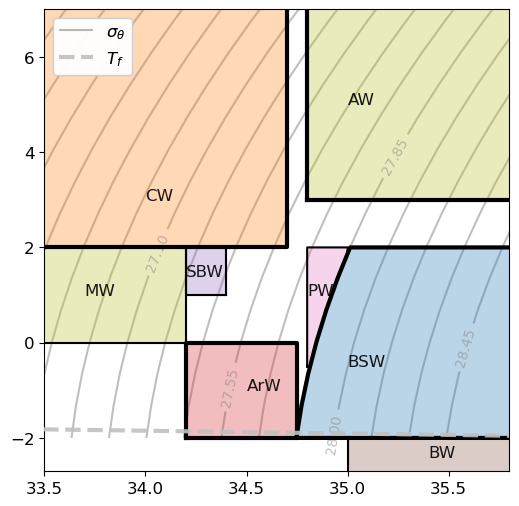

In [88]:
#POLYGONS
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1)
plt.ylim(-2.7,7)
plt.xlim(33.5,35.8)

#[[34,34.8], [-2.3, 0.5]]

shapes = np.array([])
shapelabels = np.array([])
plt.rcParams.update({'font.size': 12})

# get the colormap
# cmap = plt.get_cmap('gray_r',20).copy()
cmap = plt.get_cmap('rainbow',20).copy()
cmap = truncate_colormap(cmap, 0.1)
cmap.set_under(color='white')

# Add the potential density lines
cs = ax.contour(
    si, ti, dens2,
    colors="grey",
    zorder=1,
    alpha=0.5,
    levels=np.arange(24.1, 28.5, 0.15)  # explicitly include 27.85
)

# Optional: round to match label format
cs.levels = np.round(cs.levels, 2)

# Add labels, with one location placed on the 27.85 contour
manual_locations = [
    (34.0, 2.0),
    (34.5, -1.0),
    (35.2, 4),
    (35.5, 0.0),
    (34.9, -1.9)  # try to place this on the 27.85 contour
]

cl = plt.clabel(
    cs,
    fontsize=10,
    fmt="%.2f",  # switch to two decimals to show 27.85
    manual=manual_locations
)

h, l = cs.legend_elements()
h = np.array([h[0]],dtype=object)
l = np.array(["$\sigma_{θ}$"])

# add the freezing temperature
fline = plt.plot(si,Freez_temp,'-',color='silver',linestyle="dashed",label="$T_{f}$",alpha=0.9,zorder=9,linewidth=3)
h = np.append(h,fline)
l = np.append(l,"$T_{f}$")


# MAIN WATER MASSES
# BSW values
x, y = bsw.exterior.xy
bsw2 = plt.plot(x, y,label="BSW",color="black",zorder=5,linewidth=3)
plt.fill(x, y,alpha=0.3,color="tab:blue")
shapes = np.append(shapes,bsw2)
shapelabels = np.append(shapelabels,"BSW")

# CW values
x, y = cw.exterior.xy
cw2 = plt.plot(x, y,label="CW",color="black",zorder=5,linewidth=3)
plt.fill(x, y,alpha=0.3,color="tab:orange")
shapes = np.append(shapes,cw2)
shapelabels = np.append(shapelabels,"CW")

# ArW values
x, y = arw.exterior.xy
arw2 = plt.plot(x, y,label="ArW",color="black",zorder=5,linewidth=3)
plt.fill(x, y,alpha=0.3,color="tab:red")
shapes = np.append(shapes,arw2)
shapelabels = np.append(shapelabels,"ArW")

# AW values
x, y = aw.exterior.xy
aw2 = plt.plot(x, y,label="AW",color="black",zorder=5,linewidth=3)
plt.fill(x, y,alpha=0.3,color="tab:olive")
shapes = np.append(shapes,msw2)
shapelabels = np.append(shapelabels,"AW")

# SECONDARY WATER MASSES
# mw
x, y = mw.exterior.xy
mw2 = plt.plot(x, y,label="MW",color="black",zorder=5)
plt.fill(x, y,alpha=0.3,color="tab:olive")
shapes = np.append(shapes,mw2)
shapelabels = np.append(shapelabels,"MW")

# sbw
x, y = sbw.exterior.xy
sbw2 = plt.plot(x, y,label="SBW",color="black",zorder=5)
plt.fill(x, y,alpha=0.3,color="tab:purple")
shapes = np.append(shapes,sbw2)
shapelabels = np.append(shapelabels,"SBW")

# bw
x, y = bw.exterior.xy
bw2 = plt.plot(x, y,label="BW",color="black",zorder=5)
plt.fill(x, y,alpha=0.3,color="tab:brown")
shapes = np.append(shapes,bw2)
shapelabels = np.append(shapelabels,"BW")

# pw
x, y = pw.exterior.xy
pw2 = plt.plot(x, y,label="PW",color="black",zorder=5)
plt.fill(x, y,alpha=0.3,color="tab:pink")
shapes = np.append(shapes,pw2)
shapelabels = np.append(shapelabels,"PW")

plt.text(x=35, y=-0.5,s="BSW",fontsize=12,alpha=0.9,zorder=5,color="black")
plt.text(x=34, y=3,s="CW",fontsize=12,alpha=0.9,zorder=5,color="black")
plt.text(x=34.5, y=-1,s="ArW",fontsize=12,alpha=0.9,zorder=5,color="black")
plt.text(x=35, y=5,s="AW",fontsize=12,alpha=0.9,zorder=5,color="black")
plt.text(x=33.7, y=1,s="MW",fontsize=12,alpha=0.9,zorder=5,color="black")
plt.text(x=34.2, y=1.4,s="SBW",fontsize=12,alpha=0.9,zorder=5,color="black")
plt.text(x=35.4, y=-2.4,s="BW",fontsize=12,alpha=0.9,zorder=5,color="black")
plt.text(x=34.8, y=1,s="PW",fontsize=12,alpha=0.9,zorder=5,color="black")


# labels and plot
legend1 = plt.legend(h,l, loc=2)
plt.gca().add_artist(legend1)

plt.savefig("figs/labels.png",dpi=300)
#plt.legend(shapes,shapelabels, loc=1)

In [93]:
gates

['BSO', 'SFJ', 'FJNZ']

In [102]:
# plot the average per-season T and S profile at each of the gates and take an outline of what is what

seasons = {
    "DJF": [11, 0, 1],  # Dec, Jan, Feb
    "MAM": [2, 3, 4],
    "JJA": [5, 6, 7],
    "SON": [8, 9, 10]
}

season_labels = ["DJF", "MAM", "JJA", "SON"]

theta_seasonal_avg = {}
salt_seasonal_avg = {}

# Map years to index
year_to_idx = {year: idx for idx, year in enumerate(allyears)}

for gate in gates:
    theta_data = theta_timeseries[gate]  # (nyears, 12, nz, nx)
    salt_data = salt_timeseries[gate]

    theta_seasonal_avg[gate] = {}
    salt_seasonal_avg[gate] = {}

    for season in season_labels:
        for year in allyears:
            if year < 2006:
                continue

            try:
                if season == "DJF":
                    # Need Dec of previous year
                    idx_curr = year_to_idx[year]
                    idx_prev = year_to_idx[year - 1]

                    dec = theta_data[idx_prev, 11]
                    jan = theta_data[idx_curr, 0]
                    feb = theta_data[idx_curr, 1]
                    theta_season = np.nanmean(np.stack([dec, jan, feb]), axis=0)

                    dec_s = salt_data[idx_prev, 11]
                    jan_s = salt_data[idx_curr, 0]
                    feb_s = salt_data[idx_curr, 1]
                    salt_season = np.nanmean(np.stack([dec_s, jan_s, feb_s]), axis=0)
                else:
                    months = seasons[season]
                    idx = year_to_idx[year]
                    theta_season = np.nanmean(theta_data[idx, months, :, :], axis=0)
                    salt_season = np.nanmean(salt_data[idx, months, :, :], axis=0)

                theta_seasonal_avg[gate][f"{season}_{year}"] = theta_season
                salt_seasonal_avg[gate][f"{season}_{year}"] = salt_season

            except KeyError:
                # skip if previous year not available for DJF
                continue

In [109]:
seasonal_avg_by_gate = {}

for gate in gates:
    seasonal_avg_by_gate[gate] = {}
    
    for season in ["DJF", "MAM", "JJA", "SON"]:
        # Get all years for this gate/season
        keys = [k for k in theta_seasonal_avg[gate].keys() if k.startswith(season)]
        
        if not keys:
            continue
        
        # Stack and average temperature
        theta_stack = np.stack([theta_seasonal_avg[gate][k] for k in keys], axis=0)
        theta_clim = np.nanmean(theta_stack, axis=0)  # shape: (nz, nx)

        # Stack and average salinity
        salt_stack = np.stack([salt_seasonal_avg[gate][k] for k in keys], axis=0)
        salt_clim = np.nanmean(salt_stack, axis=0)  # shape: (nz, nx)

        # Store in dictionary
        seasonal_avg_by_gate[gate][season] = {
            "theta": theta_clim,
            "salt": salt_clim
        }

In [113]:
# Compute distances dynamically for each gate
gate_distances = {}

gate_labels = gates

for gate, (x_gate, y_gate, choose_UV_gate) in zip(gate_labels, [(x_bso, y_bso, choose_UV_bso), 
                                                                (x_sfj, y_sfj, choose_UV_sfj), 
                                                                (x_fjnz, y_fjnz, choose_UV_fjnz)]):
    distance = np.array([])
    for i in range(len(x_gate)):
        thisy = y_gate[i]
        thisx = x_gate[i]
        this_choose = choose_UV_gate[i]
        
        if this_choose == 'H':
            distance = np.append(distance, mygrid['DYG'][thisy, thisx])
        else:
            distance = np.append(distance, mygrid['DXG'][thisy, thisx])

    gate_distances[gate] = np.cumsum(distance / 1000)  # Convert to km

# Compute depth array
depths = np.cumsum(-mygrid["DRF"])  # Convert to depth in meters

In [118]:
for var in ["theta", "salt"]:
    fig, axes = plt.subplots(3, 4, figsize=(20, 10), sharex=False, sharey=True)
    fig.suptitle(f"Climatological Seasonal Mean {var.capitalize()} (2006–present)", fontsize=16)

    for row, gate in enumerate(gates):
        x_vals = gate_distances[gate]  # Convert to km
        y_vals = np.cumsum(-mygrid["DRF"])    # Depth in m (negative downward)

        for col, season in enumerate(seasons):
            data = seasonal_avg_by_gate[gate][season][var]
            data_masked = np.where(data == 0, np.nan, data)

            ax = axes[row, col]
            cmap = "coolwarm" if var == "theta" else "viridis"
            vmin = -2 if var == "theta" else 33
            vmax = 4 if var == "theta" else 35

            # Ensure x and y are 2D meshgrids for pcolormesh
            x2d, y2d = np.meshgrid(x_vals, y_vals)

            # Plot with pcolormesh
            pcm = ax.pcolormesh(x2d, y2d, data_masked, cmap=cmap, shading="auto", vmin=vmin, vmax=vmax)

            ax.set_title(f"{gate} – {season}")
            ax.set_ylim(y_vals.min(), y_vals.max())  # Depth axis (negative down)
            if col == 0:
                ax.set_ylabel("Depth (m)")
            if row == 2:
                ax.set_xlabel(x_labels[gate])

            if col == 3:
                cbar = fig.colorbar(pcm, ax=ax, orientation="vertical", shrink=0.8)
                unit = "°C" if var == "theta" else "PSU"
                cbar.set_label(f"{var.capitalize()} ({unit})")

            ax.set_ylim(-500, -5)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f"figs/Seasonal_Mean_{var}_3x4.png", dpi=300)
    plt.close()

# classify these using the existing definitions of water masses

In [119]:
# start with the mean seasonal distribution of the array

# Define water mass polygons and labels
water_mass_polygons = {
    'BSW': bsw,
    'CW': cw,
    'ArW': arw,
    'AW': aw,
    'MW': mw,
    'SBW': sbw,
    'BW': bw,
    'PW': pw
}

# Assign each water mass a numeric ID and color
wm_to_id = {name: i for i, name in enumerate(water_mass_polygons.keys())}
wm_colors = {
    'BSW': 'black',
    'CW': 'blue',
    'ArW': 'skyblue',
    'AW': 'red',
    'MW': 'orange',
    'SBW': 'purple',
    'BW': 'navy',
    'PW': 'green'
}

# Initialize classification dictionary
watermass_class_by_gate = {}

for gate in gates:
    watermass_class_by_gate[gate] = {}
    x_vals = gate_distances[gate] / 1000  # in km
    y_vals = np.cumsum(-mygrid['DRF'])

    for season in ["DJF", "MAM", "JJA", "SON"]:
        theta = seasonal_avg_by_gate[gate][season]['theta']
        salt = seasonal_avg_by_gate[gate][season]['salt']

        nz, nx = theta.shape
        wm_class = np.full((nz, nx), fill_value=np.nan)

        for i in range(nz):
            for j in range(nx):
                t = theta[i, j]
                s = salt[i, j]

                if np.isnan(t) or np.isnan(s):
                    continue

                pt = Point(s, t)  # (x=salt, y=theta)
                for wm_name, poly in water_mass_polygons.items():
                    if poly.contains(pt):
                        wm_class[i, j] = wm_to_id[wm_name]
                        break

        watermass_class_by_gate[gate][season] = wm_class

In [130]:
wm_names

['BSW', 'CW', 'ArW', 'AW', 'MW', 'SBW', 'BW', 'PW', 'Unclassified']

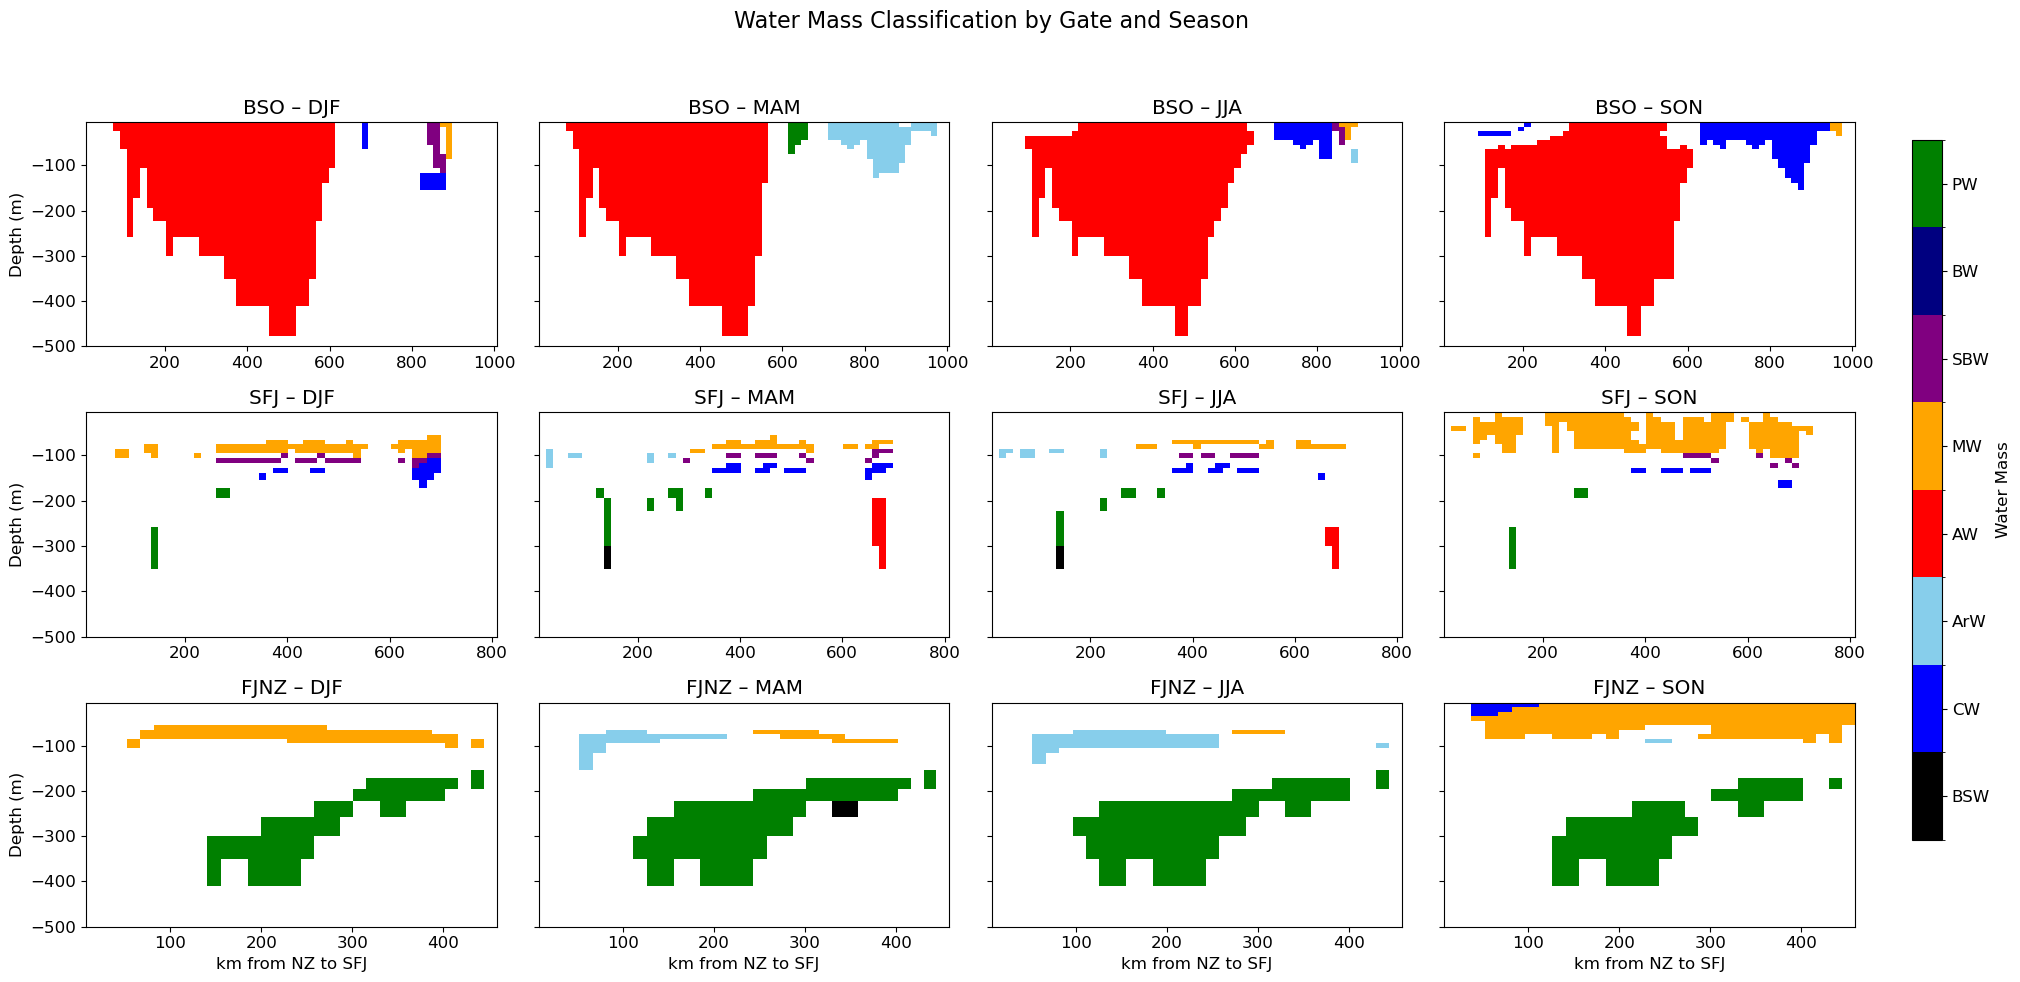

In [135]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy.ma as ma

# Define water mass names and their assigned colors
wm_names = list(wm_to_id.keys())  # only real water masses (no "Unclassified")
wm_colors_list = [wm_colors[wm] for wm in wm_names]

nclasses = len(wm_names)  # e.g., 8
boundaries = np.arange(-0.5, nclasses + 0.5, 1)  # [−0.5, 0.5, ..., 7.5] → 8 bins

# Setup colormap and norm (no color for NaNs)
cmap = ListedColormap(wm_colors_list)
norm = BoundaryNorm(boundaries=boundaries, ncolors=nclasses)

# Create figure
fig, axes = plt.subplots(3, 4, figsize=(20, 10), sharex=False, sharey=True)
fig.suptitle("Water Mass Classification by Gate and Season", fontsize=16)

for row, gate in enumerate(gates):
    x = gate_distances[gate]  # km
    y = np.cumsum(-mygrid['DRF'])    # depth

    for col, season in enumerate(["DJF", "MAM", "JJA", "SON"]):
        wm_class = watermass_class_by_gate[gate][season].copy()  # shape (nz, nx)

        # Mask all NaNs (i.e., unmatched or invalid)
        wm_masked = ma.masked_invalid(wm_class)

        x2d, y2d = np.meshgrid(x, y)
        ax = axes[row, col]
        im = ax.pcolormesh(x2d, y2d, wm_masked, cmap=cmap, norm=norm, shading='auto')

        ax.set_title(f"{gate} – {season}")
        ax.set_ylim(-500, -5)
        if col == 0:
            ax.set_ylabel("Depth (m)")
        if row == 2:
            ax.set_xlabel(x_labels[gate])

# # Colorbar to far right
# divider = make_axes_locatable(axes[0, -1])
# cax = divider.append_axes("right", size="5%", pad=0.1)
# cbar = fig.colorbar(im, cax=cax, ticks=np.arange(nclasses))
# cbar.ax.set_yticklabels(wm_names)
# cbar.set_label("Water Mass")

# [left, bottom, width, height] in figure coordinates (0 to 1)
cbar_ax = fig.add_axes([0.96, 0.15, 0.015, 0.7])  # tall and narrow
cbar = fig.colorbar(im, cax=cbar_ax, ticks=np.arange(nclasses))
cbar.ax.set_yticklabels(wm_names)
cbar.set_label("Water Mass", fontsize=12)

plt.tight_layout(rect=[0, 0, 0.95, 0.95])
plt.savefig("figs/WaterMass_Classification_3x4.png", dpi=300)
plt.show()